# 利用LightGBM對完美世界玩家做價值客戶分類

## import 套件

In [1]:
import lightgbm as lgb

#lgb中專門應對分類問題的函數
from lightgbm import LGBMClassifier

In [2]:
#忽略掉瑣碎的警告訊息
import warnings
warnings.filterwarnings("ignore")

#######################################################################################
import matplotlib
import matplotlib.pyplot as plt
#matplotlib內建不支援中文，解決辦法：每次預先指定字體
matplotlib.rcParams.update({'font.size': 36})
matplotlib.use('qt4agg')
myfont = matplotlib.font_manager.FontProperties(fname='C:\\Windows\\Fonts\\msjh.ttc')
#指定字體
matplotlib.rcParams['axes.unicode_minus']=False
%matplotlib inline 
#繪圖完就直接顯示該圖，省略每次繪圖完都要輸入plt.show指令的動作
#######################################################################################
import seaborn as sns
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
pd.set_option('display.max_columns', 100)  #設定可顯示欄位的上限
pd.options.display.float_format = '{:,.6f}'.format  #設定浮點數的格式

import numpy as np
from scipy.special import boxcox1p
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score

#模型參數調整用的套件
from skopt import BayesSearchCV  
from skopt.space import Integer

## 資料預處理

In [3]:
data = pd.read_excel('GF_RFMmodelExample_20180507_W2.xlsx', encoding='utf8')
data.head(1)

,遊戲名稱,遊戲帳號,時間Key,RFM數字類型,RFM中文類型,價值指數,第一次儲值日期,最後一次儲值日期,平均儲值日期間隔,平均儲值日期區間,儲值次數,平均儲值金額,平均儲值金額區間,累積儲值金額,累積儲值金額區間,角色等級,最近上線時間,角色職業,修真,轉生級別,境界,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級
0,完美世界,31800459,2016-12-31,111,-_新戶,0.033000,2016-04-24,2016-04-24,251.000000,超過3個月,1,150,1K,150,1K,nan,NaT,NaN,NaN,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171030 entries, 0 to 171029
Data columns (total 32 columns):
遊戲名稱        171030 non-null object
遊戲帳號        171030 non-null object
時間Key       171030 non-null datetime64[ns]
RFM數字類型     171030 non-null int64
RFM中文類型     171030 non-null object
價值指數        171030 non-null float64
第一次儲值日期     171030 non-null datetime64[ns]
最後一次儲值日期    171030 non-null datetime64[ns]
平均儲值日期間隔    171030 non-null float64
平均儲值日期區間    171030 non-null object
儲值次數        171030 non-null int64
平均儲值金額      171030 non-null int64
平均儲值金額區間    171030 non-null object
累積儲值金額      171030 non-null int64
累積儲值金額區間    171030 non-null object
角色等級        92265 non-null float64
最近上線時間      88298 non-null datetime64[ns]
角色職業        97510 non-null object
修真          97510 non-null object
轉生級別        97482 non-null float64
境界          97482 non-null object
魔書經驗        97510 non-null float64
星運          97510 non-null float64
魂力          97510 non-null float64
傷害力指數       97510 non-n

In [5]:
data.describe()

,RFM數字類型,價值指數,平均儲值日期間隔,儲值次數,平均儲值金額,累積儲值金額,角色等級,轉生級別,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級
count,"171,030.000000","171,030.000000","171,030.000000","171,030.000000","171,030.000000","171,030.000000","92,265.000000","97,482.000000","97,510.000000","97,510.000000","97,510.000000","97,510.000000","97,510.000000","97,510.000000","97,482.000000","97,482.000000","97,482.000000","97,482.000000","97,482.000000"
mean,271.554517,0.467830,160.898417,71.462755,707.099813,"68,007.684997","1,756.791860",1.675745,"168,882,563.991970",2.349790,"19,459.601692","81,731.849092","220,221.017157","216,655.446129",10.393365,15.341242,5.649535,0.324255,87.823762
std,168.430057,0.765402,245.976406,155.945758,859.546544,"244,891.956862",732.895805,0.714073,"355,110,350.361300",1.594241,"8,450.452291","116,751.516641","330,171.287630","164,043.503165",12.509330,19.263134,1.593973,0.714073,36.264127
min,111.000000,0.033000,0.030000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112.000000,0.066000,21.430000,3.000000,300.000000,"1,150.000000","2,101.000000",2.000000,0.000000,1.000000,"15,541.000000","19,474.000000","25,808.000000","125,307.000000",0.000000,0.000000,4.000000,0.000000,100.000000
50%,213.000000,0.165000,66.450000,17.000000,500.000000,"8,000.000000","2,103.000000",2.000000,"1,241,311.000000",3.000000,"17,051.500000","46,719.000000","102,116.000000","205,252.000000",9.000000,5.000000,5.000000,0.000000,102.000000
75%,422.000000,0.496000,201.387500,74.000000,844.000000,"44,000.000000","2,105.000000",2.000000,"128,003,933.000000",4.000000,"20,207.000000","93,459.000000","272,682.000000","284,880.500000",19.000000,30.000000,7.000000,0.000000,105.000000
max,555.000000,4.135000,"3,775.000000","6,000.000000","30,000.000000","14,728,950.000000","2,105.000000",2.000000,"1,800,000,000.000000",8.000000,"56,835.000000","1,465,619.000000","4,063,414.000000","1,348,603.000000",41.000000,50.000000,8.000000,2.000000,105.000000


In [6]:
#data['角色職業'].value_counts()
data.groupby('修真')['修真_未填坑'].describe()

,count,mean,std,min,25%,50%,75%,max
修真,,,,,,,,
00大乘以下,"11,085.000000",37.984574,2.420373,33.000000,37.000000,38.000000,40.000000,41.000000
20上仙,"3,795.000000",21.000000,0.000000,21.000000,21.000000,21.000000,21.000000,21.000000
21真仙,"5,148.000000",20.000000,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000
22天仙,"11,971.000000",19.000000,0.000000,19.000000,19.000000,19.000000,19.000000,19.000000
30狂魔,"3,047.000000",11.000000,0.000000,11.000000,11.000000,11.000000,11.000000,11.000000
31魔聖,"4,281.000000",10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000
32魔尊,"10,679.000000",9.000000,0.000000,9.000000,9.000000,9.000000,9.000000,9.000000
40混元,"9,565.000000",1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
41至聖,"37,911.000000",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
#角色職業的遺失值由最多人選擇的職業來填補
data['角色職業'] = data['角色職業'].fillna(data['角色職業'].value_counts().index[0])

#修真未填坑等於0，代表修真部分玩家已經全玩過，因此填代表修真最高等級的41至聖
data.loc[(data.修真.isnull()) & (data['修真_未填坑']==0), '修真']='41至聖'

#根據已知修真類別來填補修真_未填坑的遺失值
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='00大乘以下'), '修真_未填坑']=38
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='20上仙'), '修真_未填坑']=21
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='22天仙'), '修真_未填坑']=20
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='21真仙'), '修真_未填坑']=19
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='30狂魔'), '修真_未填坑']=11
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='31魔聖'), '修真_未填坑']=10
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='32魔尊'), '修真_未填坑']=9
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='40混元'), '修真_未填坑']=1
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='41至聖'), '修真_未填坑']=0


#根據已知星運類別來填補星運_未填坑的遺失值
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==0), '星運_未填坑']=8
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==1), '星運_未填坑']=7
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==2), '星運_未填坑']=6
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==3), '星運_未填坑']=5
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==4), '星運_未填坑']=4
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==5), '星運_未填坑']=3
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==6), '星運_未填坑']=2
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==7), '星運_未填坑']=1
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==8), '星運_未填坑']=0

## 極端值的處理辦法：對偏度高的特徵採取box-cox轉換，使其接近常態分布
### 關於box-cox轉換的詳細介紹，可參考http://onlinestatbook.com/2/transformations/box-cox.html

Text(0.5,1,'累積儲值金額 distribution')

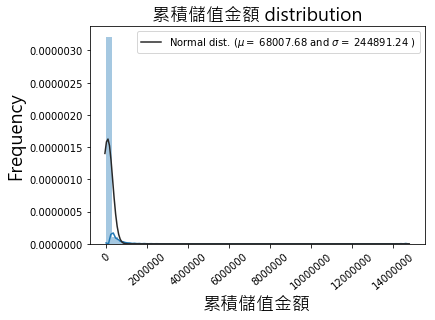

In [8]:
majorFormatter = FormatStrFormatter('%0.f') #設定圖表浮點數的格式

g = sns.distplot(data['累積儲值金額'], fit=norm)
(mu, sigma) = norm.fit(data['累積儲值金額'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency',fontproperties=myfont, fontsize=18)
g.xaxis.set_major_formatter(majorFormatter)
plt.xlabel('累積儲值金額', fontproperties=myfont, fontsize=18)
plt.xticks(rotation=40)
plt.title('累積儲值金額 distribution',fontproperties=myfont, fontsize=18)

Text(0.5,1,'累積儲值金額 distribution')

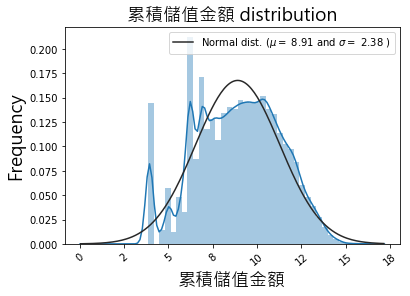

In [9]:
data['累積儲值金額'] = boxcox1p(data['累積儲值金額'], 0)

g = sns.distplot(data['累積儲值金額'], fit=norm)
(mu, sigma) = norm.fit(data['累積儲值金額'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency',fontproperties=myfont, fontsize=18)
g.xaxis.set_major_formatter(majorFormatter)
plt.xlabel('累積儲值金額', fontproperties=myfont, fontsize=18)
plt.xticks(rotation=40)
plt.title('累積儲值金額 distribution',fontproperties=myfont, fontsize=18)

In [10]:
data.describe()

,RFM數字類型,價值指數,平均儲值日期間隔,儲值次數,平均儲值金額,累積儲值金額,角色等級,轉生級別,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級
count,"171,030.000000","171,030.000000","171,030.000000","171,030.000000","171,030.000000","171,030.000000","92,265.000000","97,482.000000","97,510.000000","97,510.000000","97,510.000000","97,510.000000","97,510.000000","97,510.000000","97,482.000000","97,482.000000","97,510.000000","97,482.000000","97,482.000000"
mean,271.554517,0.467830,160.898417,71.462755,707.099813,8.907846,"1,756.791860",1.675745,"168,882,563.991970",2.349790,"19,459.601692","81,731.849092","220,221.017157","216,655.446129",10.393365,15.341242,5.650210,0.324255,87.823762
std,168.430057,0.765402,245.976406,155.945758,859.546544,2.378125,732.895805,0.714073,"355,110,350.361300",1.594241,"8,450.452291","116,751.516641","330,171.287630","164,043.503165",12.509330,19.263134,1.594241,0.714073,36.264127
min,111.000000,0.033000,0.030000,1.000000,1.000000,0.693147,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112.000000,0.066000,21.430000,3.000000,300.000000,7.048386,"2,101.000000",2.000000,0.000000,1.000000,"15,541.000000","19,474.000000","25,808.000000","125,307.000000",0.000000,0.000000,4.000000,0.000000,100.000000
50%,213.000000,0.165000,66.450000,17.000000,500.000000,8.987322,"2,103.000000",2.000000,"1,241,311.000000",3.000000,"17,051.500000","46,719.000000","102,116.000000","205,252.000000",9.000000,5.000000,5.000000,0.000000,102.000000
75%,422.000000,0.496000,201.387500,74.000000,844.000000,10.691968,"2,105.000000",2.000000,"128,003,933.000000",4.000000,"20,207.000000","93,459.000000","272,682.000000","284,880.500000",19.000000,30.000000,7.000000,0.000000,105.000000
max,555.000000,4.135000,"3,775.000000","6,000.000000","30,000.000000",16.505326,"2,105.000000",2.000000,"1,800,000,000.000000",8.000000,"56,835.000000","1,465,619.000000","4,063,414.000000","1,348,603.000000",41.000000,50.000000,8.000000,2.000000,105.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171030 entries, 0 to 171029
Data columns (total 32 columns):
遊戲名稱        171030 non-null object
遊戲帳號        171030 non-null object
時間Key       171030 non-null datetime64[ns]
RFM數字類型     171030 non-null int64
RFM中文類型     171030 non-null object
價值指數        171030 non-null float64
第一次儲值日期     171030 non-null datetime64[ns]
最後一次儲值日期    171030 non-null datetime64[ns]
平均儲值日期間隔    171030 non-null float64
平均儲值日期區間    171030 non-null object
儲值次數        171030 non-null int64
平均儲值金額      171030 non-null int64
平均儲值金額區間    171030 non-null object
累積儲值金額      171030 non-null float64
累積儲值金額區間    171030 non-null object
角色等級        92265 non-null float64
最近上線時間      88298 non-null datetime64[ns]
角色職業        171030 non-null object
修真          97510 non-null object
轉生級別        97482 non-null float64
境界          97482 non-null object
魔書經驗        97510 non-null float64
星運          97510 non-null float64
魂力          97510 non-null float64
傷害力指數       97510 no

In [12]:
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44782 entries, 15 to 171029
Data columns (total 32 columns):
遊戲名稱        44782 non-null object
遊戲帳號        44782 non-null object
時間Key       44782 non-null datetime64[ns]
RFM數字類型     44782 non-null int64
RFM中文類型     44782 non-null object
價值指數        44782 non-null float64
第一次儲值日期     44782 non-null datetime64[ns]
最後一次儲值日期    44782 non-null datetime64[ns]
平均儲值日期間隔    44782 non-null float64
平均儲值日期區間    44782 non-null object
儲值次數        44782 non-null int64
平均儲值金額      44782 non-null int64
平均儲值金額區間    44782 non-null object
累積儲值金額      44782 non-null float64
累積儲值金額區間    44782 non-null object
角色等級        44782 non-null float64
最近上線時間      44782 non-null datetime64[ns]
角色職業        44782 non-null object
修真          44782 non-null object
轉生級別        44782 non-null float64
境界          44782 non-null object
魔書經驗        44782 non-null float64
星運          44782 non-null float64
魂力          44782 non-null float64
傷害力指數       44782 non-null float64
生

## 建立樣本標籤
### 將屬於退坑、停滯、停儲狀態的玩家分類為非價值客戶。

In [13]:
data['isvalue'] = 1

data.loc[data['RFM中文類型']=='N_停儲' ,'isvalue']=0
data.loc[data['RFM中文類型']=='N_停滯' ,'isvalue']=0
data.loc[data['RFM中文類型']=='N_退坑' ,'isvalue']=0

data['isvalue'].value_counts()

0    28743
1    16039
Name: isvalue, dtype: int64

In [14]:
df = data[['平均儲值日期間隔','儲值次數', '平均儲值金額','角色等級','累積儲值金額',
           '傷害力指數', '生存指數', '聲望', 'isvalue', '星運', '魂力',
           '魔書經驗', '傷害力指數', '生存指數', '聲望', '修真_未填坑',
           '境界_未填坑', '星運_未填坑', '一轉等級', '角色職業']]

In [15]:
#one-hot encoding
df = pd.get_dummies(df, columns=['角色職業'])

In [16]:
y = df['isvalue']
df = df.drop(['isvalue'], axis=1)

## 切分訓練、驗證樣本

In [17]:
#使用sklearn中 train_test_split函數來切分數據
train_x, val_x, train_y, val_y = train_test_split(df, y, 
                                                  random_state = 0,
                                                  test_size=0.2)

In [18]:
print(train_x.shape, val_x.shape)

(35825, 30) (8957, 30)


In [19]:
train_x.sample()

,平均儲值日期間隔,儲值次數,平均儲值金額,角色等級,累積儲值金額,傷害力指數,生存指數,聲望,星運,魂力,魔書經驗,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,一轉等級,角色職業_刺客,角色職業_劍靈,角色職業_夜影,角色職業_妖獸,角色職業_妖精,角色職業_巫師,角色職業_月仙,角色職業_武俠,角色職業_法師,角色職業_羽芒,角色職業_羽靈,角色職業_魅靈
6596,622.000000,1,500,"2,101.000000",6.216606,"11,481.000000","16,624.000000","36,923.000000",1.000000,"15,257.000000",0.000000,"11,481.000000","16,624.000000","36,923.000000",21.000000,41.000000,7.000000,100.000000,0,1,0,0,0,0,0,0,0,0,0,0


## 建立模型
### baseline model為使用預設參數的 lgb分類器作為模型間效能比較基準

In [20]:
model = LGBMClassifier()

#顯示模型的參數
model.get_params()

{'boosting_type': 'gbdt',
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_bin': 255,
 'max_depth': -1,
 'min_child_samples': 10,
 'min_child_weight': 5,
 'min_split_gain': 0,
 'n_estimators': 10,
 'nthread': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'reg_alpha': 0,
 'reg_lambda': 0,
 'seed': 0,
 'silent': True,
 'subsample': 1,
 'subsample_for_bin': 50000,
 'subsample_freq': 1}

In [21]:
#訓練模型
model.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

## 模型評估
### 利用sklearn中的cross_val_score計算出交叉驗證的表現

In [22]:
kfold = StratifiedKFold(n_splits=10,random_state=0)

In [23]:
classifiers = []
classifiers.append(model)


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, train_x, train_y, scoring = "accuracy", cv = kfold, n_jobs=-1))
    

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":['lgb']})
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,lgb,0.772533,0.005808


## 使用Skopt來調整模型參數
### 因LightGBM有許多參數可供調整，但人工調整參數太費時費力，借助Skopt(scikit-optimize)來自動化參數調整過程。

### Skopt的文檔：https://scikit-optimize.github.io/

In [24]:
#設定想要調整的參數範圍

search_params = {
    'max_depth': Integer(20, 100),
    'num_leaves': Integer(10, 200),
    'n_estimators': Integer(100,500)
}

#使用BayesSearchCV
opt = BayesSearchCV(model, search_params, n_iter=10, n_jobs=-1, verbose=0,
                    cv = kfold)
opt.fit(train_x, train_y)
#顯示最佳參數
opt.best_params_

{'max_depth': 85, 'n_estimators': 408, 'num_leaves': 176}

In [25]:
#將剛取得的最佳參數套用到分類器上
model01 = LGBMClassifier(**opt.best_params_)

In [26]:
classifiers = []
classifiers.append(model01)


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, train_x, train_y, scoring = "accuracy", cv = kfold, n_jobs=-1))
    

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['lgb']})
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,lgb,0.910426,0.003889


In [27]:
#模型在驗證樣本上的表現
model01.fit(train_x,train_y)
val_pred_label = model01.predict(val_x)

accuracy=accuracy_score(val_y,val_pred_label)
print('模型在驗證樣本上的 accuracy:', accuracy)

模型在驗證樣本上的 accuracy: 0.9147035837892151


In [28]:
#模型在驗證樣本上準確率達90%以上，應為可靠的分類器，使用該分類器預測整個Dataset的標籤
model01.fit(df,y)
all_pred_label = model01.predict(df)
all_pred_proba = model01.predict_proba(df)

accuracy=accuracy_score(y,all_pred_label)
print('模型在所有樣本上的 accuracy:', accuracy)

模型在所有樣本上的 accuracy: 0.9780938770041534


## 結論

### 根據下圖，可以發現：

### 1. 平均儲值日期間隔、儲值次數、平均儲值金額、累積儲值金額對客戶是否脫離停滯、停儲、退坑狀態有高度關聯。

### 2. 聲望、魔書經驗、生存指數、魂力等遊戲相關特徵，對客戶是否能脫離停滯、停儲、退坑等狀態有一定程度的影響。

### 3. 玩家的角色職業對於改善停滯、停儲、退坑等狀態則效果有限。

### 4. 在未填坑的遊戲素質間，星運對客戶脫離退坑、停滯、停儲的幫助遠小於境界、修真。

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text yticklabel objects>)

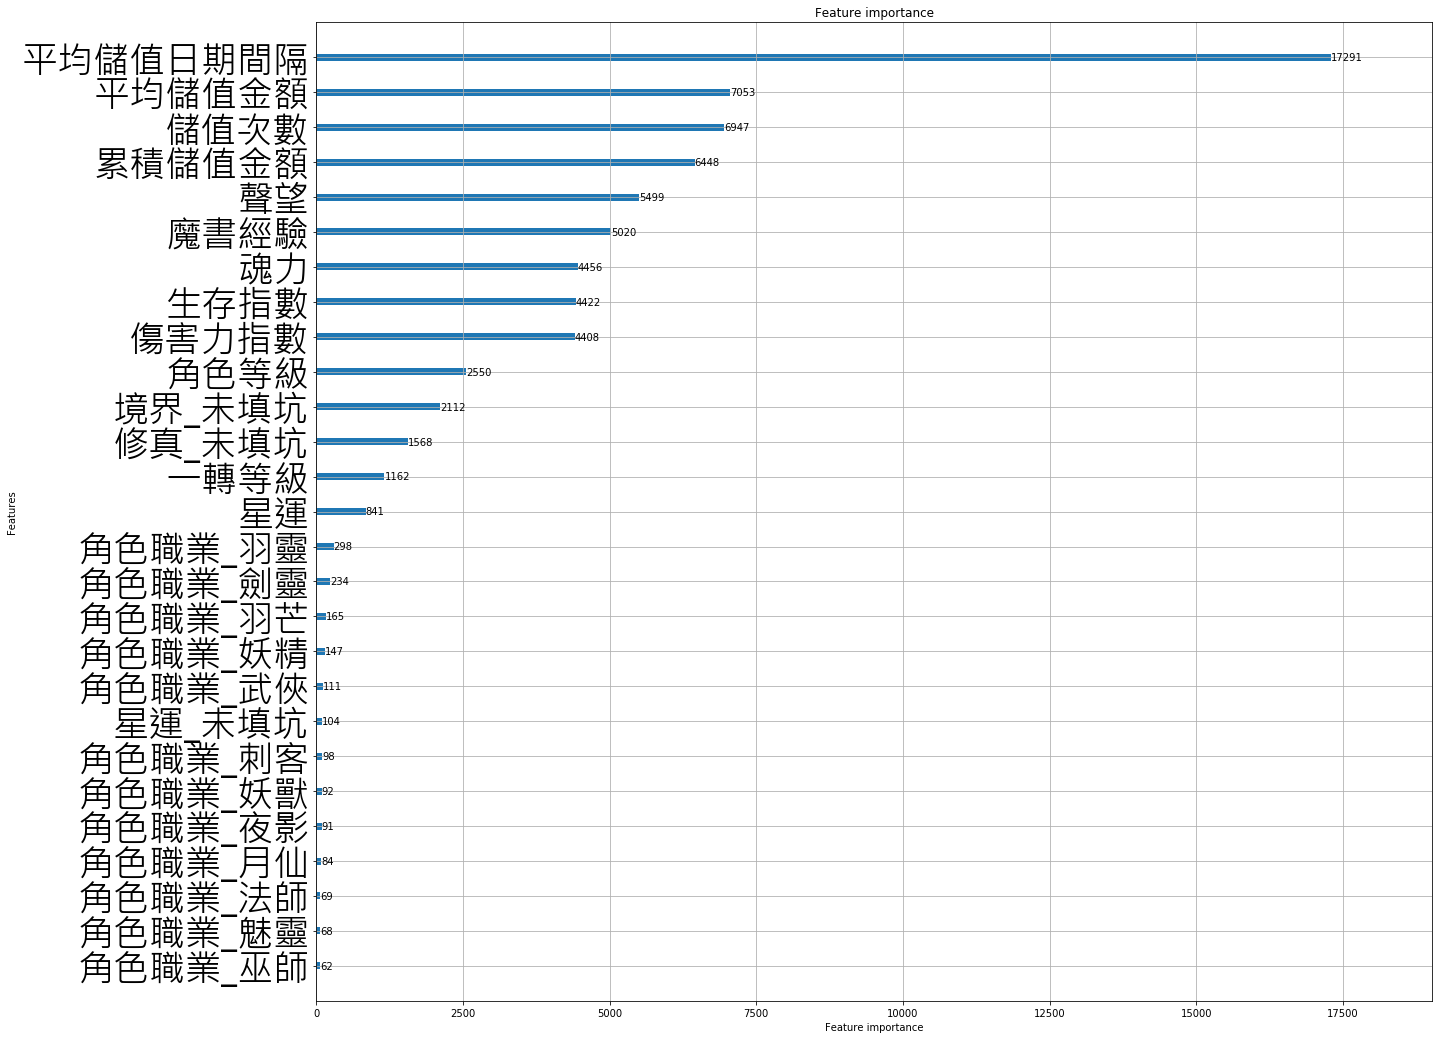

In [29]:
ax = lgb.plot_importance(model01, figsize=(20,18))
plt.yticks(fontproperties=myfont)

### 玩家脫離退坑、停滯、停儲的機率，機率由高至低排列。

In [30]:
data['預測機率'] = list(all_pred_proba[:,1])
data['預測標籤'] = list(all_pred_label)

df_停儲 = data.loc[(data['RFM中文類型'] == 'N_停儲')]
df_停滯 = data.loc[(data['RFM中文類型'] == 'N_停滯')]
df_退坑 = data.loc[(data['RFM中文類型'] == 'N_退坑')]

result = df_停儲.append(df_停滯)
result = result.append(df_退坑)

result = result.sort_values(['預測機率'], ascending=False)
result = result.drop_duplicates('遊戲帳號', keep='last')
result = result[result['預測標籤'] == 1]
result.head()

,遊戲名稱,遊戲帳號,時間Key,RFM數字類型,RFM中文類型,價值指數,第一次儲值日期,最後一次儲值日期,平均儲值日期間隔,平均儲值日期區間,儲值次數,平均儲值金額,平均儲值金額區間,累積儲值金額,累積儲值金額區間,角色等級,最近上線時間,角色職業,修真,轉生級別,境界,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級,isvalue,預測機率,預測標籤
148428,完美世界,tn0023621,2018-03-31,355,N_停儲,2.481000,2013-05-08,2017-12-29,3.490000,1週,512,1636,1K~2K,13.638417,800K~1M,"2,105.000000",2018-03-29,魅靈,41至聖,2.000000,均天十重,"836,139.000000",7.000000,"46,908.000000","353,749.000000","1,426,995.000000","512,040.000000",0.000000,0.000000,1.000000,0.000000,105.000000,0,0.861531,1
142248,完美世界,SSFish,2017-12-31,554,N_停儲,3.308000,2007-10-07,2017-09-26,6.560000,1週,570,1144,1K~2K,13.388246,500K~800K,"2,105.000000",2017-12-31,法師,41至聖,2.000000,均天十重,"2,087,864.000000",5.000000,"41,243.000000","729,213.000000","561,277.000000","354,715.000000",0.000000,0.000000,3.000000,0.000000,105.000000,0,0.854871,1
116636,完美世界,po8807,2018-05-07,255,N_停儲,1.654000,2013-09-22,2018-02-01,5.320000,1週,317,5689,5K~10K,14.405116,1M~2M,"2,105.000000",2018-04-29,法師,41至聖,2.000000,均天十重,"273,859.000000",6.000000,"51,025.000000","838,480.000000","979,939.000000","313,490.000000",0.000000,0.000000,2.000000,0.000000,105.000000,0,0.849488,1
110376,完美世界,ob0325,2018-03-31,555,N_停儲,4.135000,2007-01-12,2017-12-29,7.820000,2週,524,2430,2K~3K,14.057004,1M~2M,"2,105.000000",2018-03-29,劍靈,41至聖,2.000000,均天十重,"626,351.000000",6.000000,"49,867.000000","502,165.000000","1,990,571.000000","653,737.000000",0.000000,0.000000,2.000000,0.000000,105.000000,0,0.848834,1
57887,完美世界,godfeelings,2018-03-31,554,N_停儲,3.308000,2007-02-26,2017-12-26,6.160000,1週,658,1033,1K~2K,13.429379,500K~800K,"2,105.000000",2018-03-29,劍靈,41至聖,2.000000,均天十重,"1,201,636.000000",5.000000,"17,759.000000","130,725.000000","753,175.000000","678,876.000000",0.000000,0.000000,3.000000,0.000000,105.000000,0,0.846100,1
